### Description: In the field of agriculture finding and taking right precautions for different diseases is very important, The aim of this project is to solve this problem by building a model which can predict the disease of the plant given an input of the image

Steps to follow:
1. Unzip the data
2. Keep similar kind of images in a directory
3. Build the conv model
4. Evaluate and test the model

In [ ]:
!nvidia-smi

Sun Jun 27 04:48:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import zipfile
import os
import shutil
import random
import pathlib
import cv2
from re import search
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import natsort
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.efficientnet import EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
# 1. Unzipping the data
data = "/content/drive/MyDrive/Plant_pathology/plant-pathology-2020-fgvc7.zip"
def unzip_data(directory):
  zip_ref = zipfile.ZipFile(directory)
  zip_ref.extractall()
  zip_ref.close()
unzip_data(data)

# 2. Creating directories to keep each kind of images in it's own directories
**steps To be followed**
1. Get the directory of images
2. Load the Train and test csv files
3. Visualize few of the images to get one with data
3. sent each image to its own directory namely Healthy, Multiple diseases, Rust, Scab

In [ ]:
DIR = "/content/images"
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [ ]:
train.head()

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

In [ ]:
print(f"The total number of images available are {len(os.listdir(DIR))}")

The total number of images available are 3642


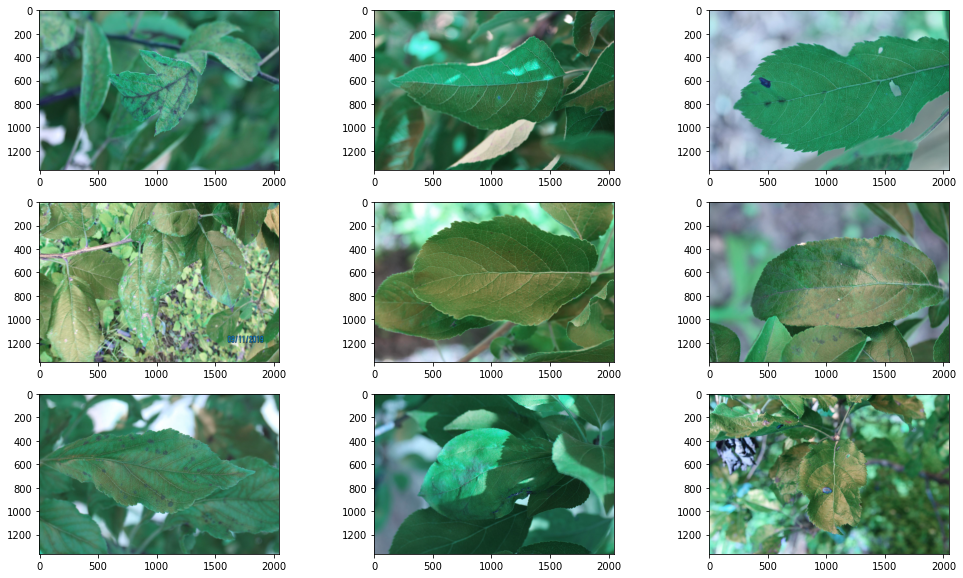

In [ ]:
# Let's visualize few of the images
def visualize_images(directory):
  image = random.sample(os.listdir(directory), 1)
  image = image[0]
  image = directory + "/" + image
  img = cv2.imread(image, cv2.COLOR_BGR2RGB)
  plt.imshow(img)

# Calling the visualize function
plt.figure(figsize=(17, 10))
for i in range(9):
  plt.subplot(3, 3, i+1)
  visualize_images(DIR)

### Make a new column in our train dataframe Labels which does the following:
1. If the row contains healthy=1 make the value in label column 0.
2.  If the row contains multiple-dieseases=1 make the value in label column 1.
3.  If the row contains rust=1 make the value in label column 2.
4.  If the row contains scab=1 make the value in label column 3.

In [ ]:
# Get the class_names
class_names = train.iloc[:, 1:].columns
print("The Different classes in Image data are:")
print(class_names)

# initialize the label column with 0's.
print("-----------------------------------------------")
print("Data Frame Before preprocessing")
number  = 0
train['label'] = 0
print(train.head())

# code to give label values in label column
print("---------------------------------------------------")
print("After preprocessing")
for class_ in class_names:
  train['label'] = train['label'] + train[class_] * number
  number = number + 1

train.head()

The Different classes in Image data are:
Index(['healthy', 'multiple_diseases', 'rust', 'scab'], dtype='object')
-----------------------------------------------
Data Frame Before preprocessing
  image_id  healthy  multiple_diseases  rust  scab  label
0  Train_0        0                  0     0     1      0
1  Train_1        0                  1     0     0      0
2  Train_2        1                  0     0     0      0
3  Train_3        0                  0     1     0      0
4  Train_4        1                  0     0     0      0
---------------------------------------------------
After preprocessing


image_id  healthy  multiple_diseases  rust  scab  label
0  Train_0        0                  0     0     1      3
1  Train_1        0                  1     0     0      1
2  Train_2        1                  0     0     0      0
3  Train_3        0                  0     1     0      2
4  Train_4        1                  0     0     0      0

In [ ]:
# split the train_dataFrame into train and validation set
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, valid_index in split.split(train, train["label"]):
  train_set = train.loc[train_index]
  test_set = train.loc[valid_index]

In [ ]:
print(train_set.shape)
print(test_set.shape)
train_set.head()

(1456, 6)
(365, 6)


image_id  healthy  multiple_diseases  rust  scab  label
1118  Train_1118        0                  0     1     0      2
1771  Train_1771        0                  0     1     0      2
179    Train_179        1                  0     0     0      0
91      Train_91        0                  0     0     1      3
931    Train_931        0                  0     1     0      2

### Steps to follow to prepare the data
* FIRSTLY split the image into train data and test data and then follow these steps to arrange them in patterns
1. Loop through all the images one by one after sorting the images
2. Find the label of image and send them to their prescribed directory
3. Inorder to send images to prescribed directories, firstly we should create directories
4. Create the directories and call the Create_train_data() function
5. Huh huh! The data is prepared

In [ ]:
def create_dataset(DIR, train_path, test_path):
  for img in os.listdir(DIR):
      #print(img)
      if img.split(".")[0] in train_set["image_id"].values:
        path = DIR + "/" + img
        #print(path)
        destination = train_path
        shutil.copy(path, destination)
      elif img.split(".")[0] in test_set["image_id"].values:
        path = DIR + "/" + img
        destination = test_path
        shutil.copy(path, destination)

# Create the directories
os.makedirs('/content/dataset/Train')
os.makedirs('/content/dataset/Test')

# call the function
train_path = '/content/dataset/Train'
test_path = '/content/dataset/Test'
create_dataset(DIR, train_path, test_path)

In [ ]:
print(f"There are {len(os.listdir('/content/dataset/Train'))} Train images")
print(f"There are {len(os.listdir('/content/dataset/Test'))} Test images")

There are 1456 Train images
There are 365 Test images


### Now create folders using the train_set and test_set and send images in the Train and Test directories to their respective locations! 

In [ ]:
# create folders in Train_data
def get_label(img):
  label = train_set.loc[train_set["image_id"]==img]['label']
  return label

def create_folders(path, healthy, multiple_diseases, rust, scab):
  images = natsort.natsorted(os.listdir(path))
  for image in images:
    src = path + "/" + image
    img = image.split('.')[0]
    label = get_label(img)
    #print(img, label)
    if search("Train",image):
      if image.split("_")[1].split(".")[0] and label.item() == 0:
        shutil.copy(src, healthy)
        os.remove(src)
      elif image.split("_")[1].split(".")[0] and label.item() == 1:
        shutil.copy(src, multiple_diseases)
        os.remove(src)
      elif image.split("_")[1].split(".")[0] and label.item() == 2:
        shutil.copy(src, rust)
        os.remove(src)
      elif image.split("_")[1].split(".")[0] and label.item() == 3:
        shutil.copy(src, scab)
        os.remove(src)

# making directories
os.makedirs("/content/dataset/Train/healthy")
os.makedirs("/content/dataset/Train/multiple_diseases")
os.makedirs("/content/dataset/Train/rust")
os.makedirs("/content/dataset/Train/scab")
# calling the function
path = "/content/dataset/Train"
healthy = "/content/dataset/Train/healthy"
multiple_diseases = "/content/dataset/Train/multiple_diseases"
rust = "/content/dataset/Train/rust"
scab = "/content/dataset/Train/scab"
create_folders(path, healthy, multiple_diseases, rust, scab)

In [ ]:
# create folders in Test_data
def get_label(img):
  label = test_set.loc[test_set["image_id"]==img]['label']
  return label

def create_folders(spath, healthy, multiple_diseases, rust, scab):
  images = natsort.natsorted(os.listdir(path))
  for image in images:
    src = path + "/" + image
    img = image.split('.')[0]
    label = get_label(img)
    #print(img, label)
    try:
      if search("Train",image):
        if image.split("_")[1].split(".")[0] and label.item() == 0:
          shutil.copy(src, healthy)
          os.remove(src)
        elif image.split("_")[1].split(".")[0] and label.item() == 1:
          shutil.copy(src, multiple_diseases)
          os.remove(src)
        elif image.split("_")[1].split(".")[0] and label.item() == 2:
          shutil.copy(src, rust)
          os.remove(src)
        elif image.split("_")[1].split(".")[0] and label.item() == 3:
          shutil.copy(src, scab)
          os.remove(src)
    except Exception as e:
      print(e)

# making directories
os.makedirs("/content/dataset/Test/healthy")
os.makedirs("/content/dataset/Test/multiple_diseases")
os.makedirs("/content/dataset/Test/rust")
os.makedirs("/content/dataset/Test/scab")
# calling the function
path = "/content/dataset/Test"
healthy = "/content/dataset/Test/healthy"
multiple_diseases = "/content/dataset/Test/multiple_diseases"
rust = "/content/dataset/Test/rust"
scab = "/content/dataset/Test/scab"
create_folders(path, healthy, multiple_diseases, rust, scab)

### Getting one with data
1. Get the class names programatically
2. Analyze the number of images in each directory
3. Radomly visualize few of the images in each category


In [ ]:
def get_class_names(parent_directory, class_names):
  path = pathlib.Path(parent_directory)
  for item in path.glob('*'):
    class_names.append(item.name)
  return class_names


# call the function
class_names = []
class_names = sorted(get_class_names('/content/dataset/Train', class_names))
print(class_names)

['healthy', 'multiple_diseases', 'rust', 'scab']


In [ ]:
def get_count(parent_directory, class_, string):
  target_dir = parent_directory + class_
  print(f"In {string} data { class_} has {len(os.listdir(target_dir))} images")
for class_ in class_names:
  get_count("/content/dataset/Train/", class_, "train")
print("_____________________________________________________________________________________")
for class_ in class_names:
  get_count("/content/dataset/Test/", class_, "Test")

In train data healthy has 413 images
In train data multiple_diseases has 73 images
In train data rust has 497 images
In train data scab has 473 images
_____________________________________________________________________________________
In Test data healthy has 103 images
In Test data multiple_diseases has 18 images
In Test data rust has 125 images
In Test data scab has 119 images


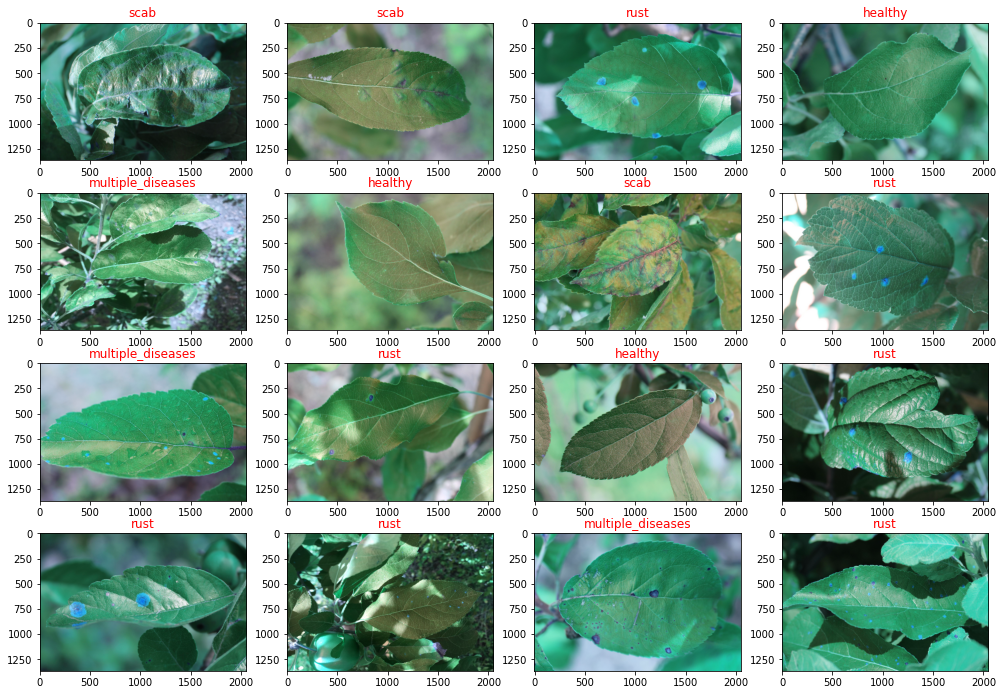

In [ ]:
def visualize_images_categorically(Directory, class_name):
  # Get the path of folder to select image
  target_dir = Directory + class_name
  # select one image randomly
  image = random.sample(os.listdir(target_dir), 1)
  image = image[0]

  # Read and plot the images
  img = cv2.imread(target_dir + "/" + image, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.title(class_name, c="r")
# select a class randomly
plt.figure(figsize=(17, 12))
for i in range(16):
  class_ = random.choice(class_names)
  plt.subplot(4, 4, i+1)
  visualize_images_categorically("/content/dataset/Train/", class_)

## Building the model
1. create test and valid data batches
2. Create a Data augmentation layer
3. Try Efficient model using Transfer learning
4. Fine Tune the model by unfreezing some of the layers
5. check how good is fine tuning working
6. evaluate the model with test images


In [ ]:
train_dir = '/content/dataset/Train'
test_dir = '/content/dataset/Test'
IMG_SIZE = 224
Batch_size = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                 image_size=(IMG_SIZE, IMG_SIZE),
                                                                 batch_size=Batch_size,
                                                                 seed=123)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=(IMG_SIZE, IMG_SIZE),
                                                                batch_size=Batch_size,
                                                                # we are keeping shuffle=False because we dont want our model to suffle the data
                                                                shuffle=False,
                                                                seed=123)



Found 1456 files belonging to 4 classes.
Found 365 files belonging to 4 classes.


In [ ]:
# now let's build a data-augmentation so we can add it to model
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
], name="Data_augmentation")

In [ ]:
# lets setup a base Efficient-net model with all its layers freezed
base_model = tf.keras.applications.efficientnet.EfficientNetB1(weights='imagenet',
                                                               include_top=False)

# 1.Freeze all the layers
base_model.trainable = False

# 2. setup the Input layer
input_layer = tf.keras.layers.Input(shape=(224, 224, 3), name="Input_layer")

# 3.Give the input_layer to dataaugmentation layer
x = data_augmentation(input_layer)

# Give the augmented inputs to basemodel
x = base_model(x, training=False)

# Create a pooling layer
x = tf.keras.layers.GlobalAveragePooling2D(name="Average_pooling")(x)

# Add the output_layer
output = tf.keras.layers.Dense(4, activation="softmax", name="output_layer")(x)

# create the final model
model = tf.keras.models.Model(input_layer, output)
model.summary()

27025408/27018416 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
Data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, None, None, 1280)  6575239   
_________________________________________________________________
Average_pooling (GlobalAvera (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 4)                 5124      
Total params: 6,580,363
Trainable params: 5,124
Non-trainable params: 6,575,239
_________________________________________________________________


In [ ]:
# create the callbacks
checkpoint_path = "basemodel_checkpint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_weights_only=True,
    save_best_only=True
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=10)

# compile the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# fit the model
history1 = model.fit(train_data,
                     epochs=10,
                     steps_per_epoch=len(train_data),
                     validation_data=test_data,
                     validation_steps=len(test_data),
                     callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/10
46/46 [==============================] - 39s 352ms/step - loss: 1.0824 - accuracy: 0.5632 - val_loss: 0.8802 - val_accuracy: 0.6630
Epoch 2/10
46/46 [==============================] - 13s 267ms/step - loss: 0.8506 - accuracy: 0.7218 - val_loss: 0.7730 - val_accuracy: 0.7205
Epoch 3/10
46/46 [==============================] - 14s 275ms/step - loss: 0.7724 - accuracy: 0.7431 - val_loss: 0.7260 - val_accuracy: 0.7370
Epoch 4/10
46/46 [==============================] - 13s 264ms/step - loss: 0.7106 - accuracy: 0.7706 - val_loss: 0.6657 - val_accuracy: 0.7726
Epoch 5/10
46/46 [==============================] - 12s 244ms/step - loss: 0.6445 - accuracy: 0.7885 - val_loss: 0.6499 - val_accuracy: 0.7589
Epoch 6/10
46/46 [==============================] - 12s 242ms/step - loss: 0.6207 - accuracy: 0.7974 - val_loss: 0.6363 - val_accuracy: 0.7671
Epoch 7/10
46/46 [==============================] - 12s 240ms/step - loss: 0.6008 - accuracy: 0.7967 - val_loss: 0.6245 - val_accuracy: 0.7616

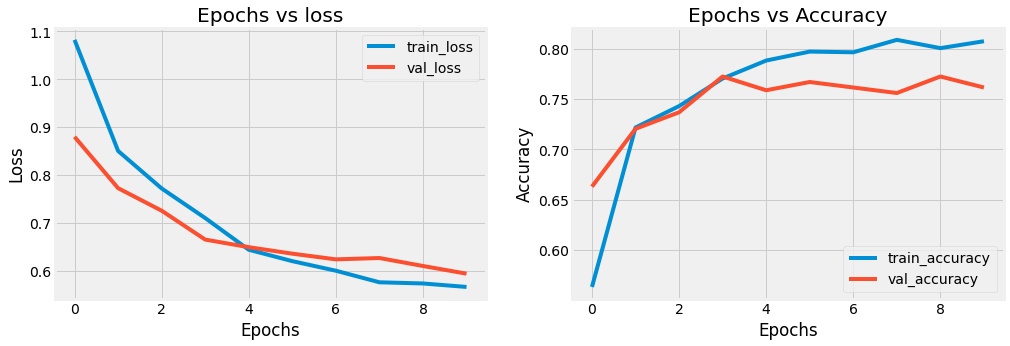

In [ ]:
# Let's visualize the loss curves
def plot_loss_curves(history):
  # get the loss values
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # get the accuracy values
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  # no of epochs
  epochs = range(len(loss))

  # plot the loss curves
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Epochs vs loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()

  # plot the accuracy curves
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Epochs vs Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()

# calling the function
plt.figure(figsize=(17, 5))
plt.style.use('fivethirtyeight')
plot_loss_curves(history1)

### now we can clearly see that both the training and validation loss are decreasing and both training and validation accuracy are increasing meaning that the model on adding more epochs wil increase the accuracy without  over fitting

### Now let's fine tune the model
1. Step1: Unfreeze all the layers
2. step2: Then Freeze all the layers except the last 5 layers
3. step3: Increase the learning-rate
4. step4: Recompile the model

In [ ]:
# unfreeze all the layers
base_model.trainable = True

# Freeze every layer except last5
for layer in base_model.layers[:-5]:
  layer.trainable = False

# Re-compile the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [ ]:
# Let's verify whether last five layers in the base model are trainable
for layer in model.layers:
  print(layer.name, layer.trainable)

Input_layer True
Data_augmentation True
efficientnetb1 True
Average_pooling True
output_layer True


In [ ]:
# we get True for base model because last 5 layers are trainable, let's dig more deep into it.
for layer in model.layers[2].layers:
  print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv Fal

In [ ]:
# fit the model
fine_tune_epochs = 20
history_fine_tune = model.fit(
    train_data,
    epochs=fine_tune_epochs,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    initial_epoch=history1.epoch[-1],
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 10/20
46/46 [==============================] - 21s 268ms/step - loss: 0.5335 - accuracy: 0.8242 - val_loss: 0.5945 - val_accuracy: 0.7753
Epoch 11/20
46/46 [==============================] - 11s 219ms/step - loss: 0.5126 - accuracy: 0.8201 - val_loss: 0.5425 - val_accuracy: 0.7918
Epoch 12/20
46/46 [==============================] - 11s 221ms/step - loss: 0.4581 - accuracy: 0.8434 - val_loss: 0.5930 - val_accuracy: 0.7781
Epoch 13/20
46/46 [==============================] - 11s 220ms/step - loss: 0.4288 - accuracy: 0.8530 - val_loss: 0.5574 - val_accuracy: 0.7918
Epoch 14/20
46/46 [==============================] - 11s 228ms/step - loss: 0.4153 - accuracy: 0.8537 - val_loss: 0.5805 - val_accuracy: 0.7863
Epoch 15/20
46/46 [==============================] - 11s 227ms/step - loss: 0.4058 - accuracy: 0.8599 - val_loss: 0.6060 - val_accuracy: 0.7726
Epoch 16/20
46/46 [==============================] - 11s 228ms/step - loss: 0.3984 - accuracy: 0.8613 - val_loss: 0.6178 - val_accuracy:

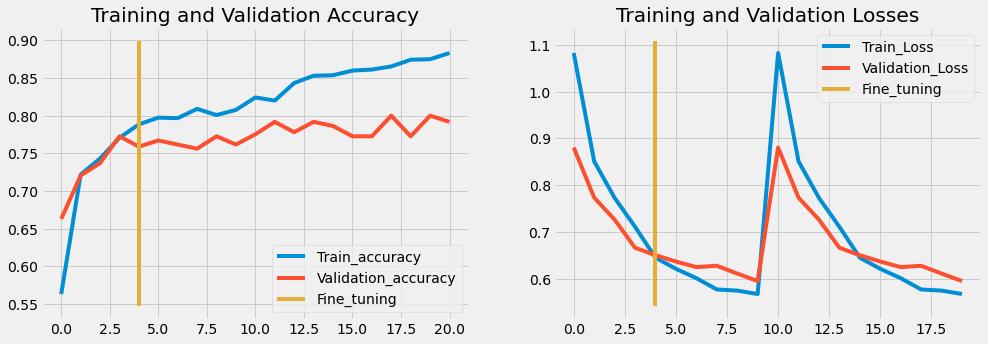

In [ ]:
# Now let's compare both the losses
def compare_curves(original_history, new_history, initial_epochs=5):
  
  # Get the base model Accuracy values
  original_accuracy = original_history.history["accuracy"]
  original_val_accuracy = original_history.history["val_accuracy"]

  # Get the base model Loss values
  original_loss = original_history.history["loss"]
  original_val_loss = original_history.history["val_loss"]

  # Get the fine tuned accuracy values
  new_accuracy = new_history.history["accuracy"]
  new_val_accuracy = new_history.history["val_accuracy"]

  # Get the fine tuned losss values
  new_loss = original_history.history["loss"]
  new_val_loss = original_history.history["val_loss"]
  
  # concatenate to get final array of values
  total_accuracy = original_accuracy + new_accuracy
  total_val_accuracy = original_val_accuracy + new_val_accuracy

  total_loss = original_loss + new_loss
  total_val_loss = original_val_loss + new_val_loss

  # plot the accuracy
  plt.subplot(1, 2, 1)
  plt.plot(total_accuracy, label="Train_accuracy")
  plt.plot(total_val_accuracy, label="Validation_accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Fine_tuning")
  plt.title("Training and Validation Accuracy")
  plt.legend()

  # plot the losses
  plt.subplot(1, 2, 2)
  plt.plot(total_loss, label="Train_Loss")
  plt.plot(total_val_loss, label="Validation_Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Fine_tuning")
  plt.title("Training and Validation Losses")
  plt.legend()

# plot the figure
plt.figure(figsize=(15, 5))
compare_curves(history1, history_fine_tune)


### we can see that fine tuning did not went that well the reasons may be because of less data we are having so it is better to build model by freezing all the layers

In [ ]:
# Rebuilding our model with all layers freezef with increase epochs
Efficient_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False,
    weights='imagenet'
)

# Freeze all the layers
Efficient_model.trainable = False

# Making the input_layer
input_layer = tf.keras.layers.Input(shape=(224, 224, 3), name="Input_layer")

# Give the input layer to Data Augmentation layer
x = data_augmentation(input_layer)

# Pass the augmented input to base Efficient_model
x = Efficient_model(x, training=False)

# pass to Global average_pooling layer
x = tf.keras.layers.GlobalAveragePooling2D(name="Average_pooling_layer")(x)

# Add a Dense output layer
output = tf.keras.layers.Dense(4, activation="relu", name="output_layer")(x)

# Create the model
model1 = tf.keras.models.Model(input_layer, output)

# compile the model
model1.compile(loss="categorical_crossentropy",
               optimizer="adam",
               metrics=["accuracy"])

# create callbacks
checkpoint_path = "Effmodel.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_weights_only=True,
    save_best_only=True,  
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_accuracy')

history2 = model1.fit(
    train_data,
    epochs=50,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[checkpoint_callback, early_stopping_callback]
)

16711680/16705208 [==============================] - 0s 0us/step
Epoch 1/50
46/46 [==============================] - 17s 231ms/step - loss: 1.8465 - accuracy: 0.4265 - val_loss: 1.7098 - val_accuracy: 0.5178
Epoch 2/50
46/46 [==============================] - 10s 198ms/step - loss: 1.7028 - accuracy: 0.5130 - val_loss: 1.8161 - val_accuracy: 0.5452
Epoch 3/50
46/46 [==============================] - 10s 207ms/step - loss: 1.6020 - accuracy: 0.6106 - val_loss: 1.7857 - val_accuracy: 0.6110
Epoch 4/50
46/46 [==============================] - 10s 194ms/step - loss: 1.5240 - accuracy: 0.6724 - val_loss: nan - val_accuracy: 0.6329
Epoch 5/50
46/46 [==============================] - 10s 198ms/step - loss: 1.5741 - accuracy: 0.6573 - val_loss: nan - val_accuracy: 0.4795
Epoch 6/50
46/46 [==============================] - 10s 197ms/step - loss: 1.5836 - accuracy: 0.6078 - val_loss: nan - val_accuracy: 0.6411
Epoch 7/50
46/46 [==============================] - 10s 197ms/step - loss: nan - accur

In [ ]:
# Save the best model
model.save('/content/drive/MyDrive/Plant_pathology/final_model.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### checking where our model made the most wrong predictons

1. Unravel the test_data so we can use their original labels to track how well the model is performing
2. Plot confusion to find where the model is doing more erros
3. Get the F1-scores and plot them in descending order
4.. Find the most wrong-predictions, that is the wrong predictions with highest prediction probability


In [ ]:
# Load the saved model and evaluate it with test-data
load_model = tf.keras.models.load_model('/content/drive/MyDrive/Plant_pathology/final_model.h5')
load_model.evaluate(test_data)

12/12 [==============================] - 18s 175ms/step - loss: 0.5753 - accuracy: 0.7918


[0.575336217880249, 0.7917808294296265]

In [ ]:
# let's see some predictions and compare them with original lables
preds_probs = load_model.predict(test_data)
preds_probs[:1]

array([[0.3092821 , 0.0755471 , 0.5446873 , 0.07048361]], dtype=float32)

In [ ]:
# unbatch the test_data
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

### In the above code The labels column in the test data is taken and converted into numpy array and it typically looks like->[1,0,0,0...0] just like one hot encoded

* Inorder to get the index of highest value we apply argmax() function

In [ ]:
# Get the predicted class names and actual class names of first 10 images

pred_probs_first10 = preds_probs[:10]
for scores in range(10):
  print(f"The predicted class is {class_names[tf.argmax(pred_probs_first10[scores])]} and the actual class is {class_names[y_labels[scores]]}")

The predicted class is rust and the actual class is healthy
The predicted class is healthy and the actual class is healthy
The predicted class is healthy and the actual class is healthy
The predicted class is rust and the actual class is healthy
The predicted class is healthy and the actual class is healthy
The predicted class is healthy and the actual class is healthy
The predicted class is rust and the actual class is healthy
The predicted class is healthy and the actual class is healthy
The predicted class is healthy and the actual class is healthy
The predicted class is multiple_diseases and the actual class is healthy


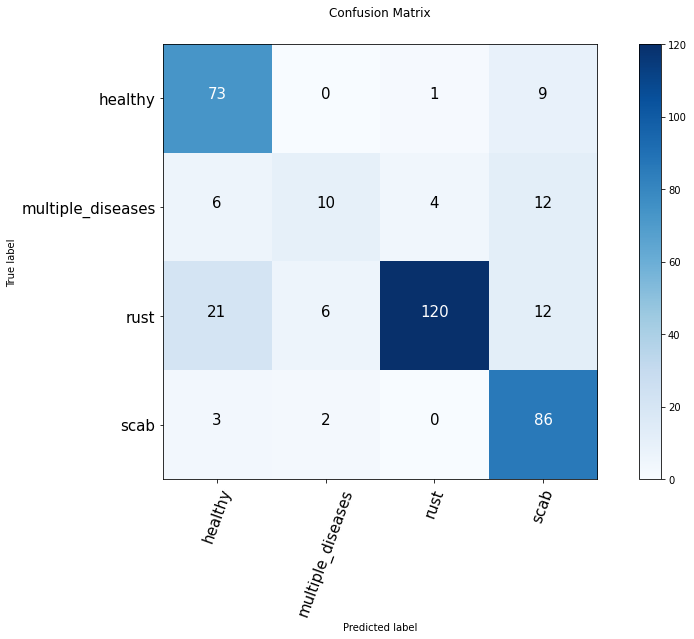

In [ ]:
# plot a confusion matrix so we can see where the models is making more wrong predictions
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix_own(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # chnaged (plot x-labels vertically)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

# call the make_confusion matrix function
make_confusion_matrix_own(tf.argmax(preds_probs, axis=1), y_labels, classes=class_names, figsize=(15, 8))

### we can observe that the model is making most wrong predctions in the case of multiple diseases
1. This may be due to wrong labelling of images
2. Or one of the diseases showing more dominance over the other
3. Now let's visualize the most wrong predicted images so we will get more detail understanding
4. Before doing the above let's check various metrics and plot the f1-scores of each class from top to bottom

In [ ]:
# Lets check the Accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(y_labels,tf.argmax(preds_probs, axis=1))

0.7917808219178082

In [ ]:
# Lets get the precision recall and f1-score using sklearn classification-report function
from sklearn.metrics import classification_report
print(classification_report(y_labels, tf.argmax(preds_probs, axis=1)))

              precision    recall  f1-score   support

           0       0.88      0.71      0.78       103
           1       0.31      0.56      0.40        18
           2       0.75      0.96      0.85       125
           3       0.95      0.72      0.82       119

    accuracy                           0.79       365
   macro avg       0.72      0.74      0.71       365
weighted avg       0.83      0.79      0.80       365



# Inorder to Visualize F1-scores
1. Create a DataFrame containing Class_names and F1-scores columns
2. Inorder to create DataFrame as above we have to get classification_report as dictionary
3. Loop through the dict and create a dictionary of key value pairs containing class_names and F1-scores excluding accuracy, macro avg, Weighted avg

In [ ]:
classification_report_dict = classification_report(y_labels, tf.argmax(preds_probs, axis=1),output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.7849462365591398,
  'precision': 0.8795180722891566,
  'recall': 0.7087378640776699,
  'support': 103},
 '1': {'f1-score': 0.39999999999999997,
  'precision': 0.3125,
  'recall': 0.5555555555555556,
  'support': 18},
 '2': {'f1-score': 0.8450704225352114,
  'precision': 0.7547169811320755,
  'recall': 0.96,
  'support': 125},
 '3': {'f1-score': 0.8190476190476191,
  'precision': 0.945054945054945,
  'recall': 0.7226890756302521,
  'support': 119},
 'accuracy': 0.7917808219178082,
 'macro avg': {'f1-score': 0.7122660695354925,
  'precision': 0.7229474996190443,
  'recall': 0.7367456238158694,
  'support': 365},
 'weighted avg': {'f1-score': 0.7976710461620807,
  'precision': 0.8301822535584411,
  'recall': 0.7917808219178082,
  'support': 365}}

In [ ]:
class_names

['healthy', 'multiple_diseases', 'rust', 'scab']

In [ ]:
class_f1_scores = {}
for k, v in classification_report_dict.items():
  if k == 'accuracy':
    break
  else:
    class_f1_scores[class_names[int(k)]] = v['f1-score']

class_f1_scores

{'healthy': 0.7849462365591398,
 'multiple_diseases': 0.39999999999999997,
 'rust': 0.8450704225352114,
 'scab': 0.8190476190476191}

In [ ]:
# Let's create a DataFrame containg f1-scores and classes
def create_f1_score_dataframe(dictionanry):
  df = pd.DataFrame({
      'class': list(dictionanry.keys()),
      'f1-scores': list(dictionanry.values())
  })
  return df

# call the function
df = create_f1_score_dataframe(class_f1_scores)
df.head()

class  f1-scores
0            healthy   0.784946
1  multiple_diseases   0.400000
2               rust   0.845070
3               scab   0.819048

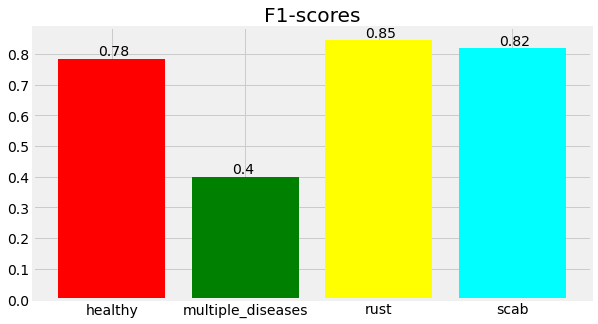

In [ ]:
# Now let's visualize the f1-scores uisng barcharts
def visualize_f1_scores(dataframe):
  plt.bar(dataframe["class"], dataframe["f1-scores"], color=["red", "green", "yellow", "cyan"])
  plt.title("F1-scores")
  for index, value in enumerate(dataframe["f1-scores"]):
    plt.text(index - 0.1, value + 0.01, str(round(value, 2)))

plt.figure(figsize=(10, 5))
plt.style.use('fivethirtyeight')
visualize_f1_scores(df)

* We know that F1-score is a combination of both precision and Recall and we have the lowest F1-score for multiple-diseases and our model is performing the worst in case of multiple-diseases.

* Now let's viusalize the most wrong predictions by this we can easily check the manual labelling errors done

*******************************************************************

#### Inorder to viusalize the most wrong prediction images we follow the following steps:
1. Create a Data Frame containing the following columns
* Path of image
* true_label
* predicted_label
* probability_confidence
* actual_class
* predicted_class
2. Create a new columns pred_status which shows whether the prediction is true or false
3. select all the rows in the dataframe having pred_status false and sort them in the descending order
4. visualize the images

In [ ]:
paths_of_images = []
# use list_files to get path of images
for path_file in test_data.list_files('/content/dataset/Test/*/*.jpg',
                                      shuffle=False):
  paths_of_images.append(path_file.numpy())

y_true = y_labels
y_pred = tf.argmax(preds_probs, axis=1)
probability_confidence = preds_probs.max(axis=1)

In [ ]:
df1 = pd.DataFrame({
    'image_path': paths_of_images,
    'y_true': y_true,
    'y_pred': y_pred,
    'prob_confidence': probability_confidence
})

df1.head()

image_path  ...  prob_confidence
0  b'/content/dataset/Test/healthy/Train_1017.jpg'  ...         0.544687
1  b'/content/dataset/Test/healthy/Train_1031.jpg'  ...         0.588743
2  b'/content/dataset/Test/healthy/Train_1058.jpg'  ...         0.910426
3  b'/content/dataset/Test/healthy/Train_1072.jpg'  ...         0.573460
4  b'/content/dataset/Test/healthy/Train_1080.jpg'  ...         0.935471

[5 rows x 4 columns]

In [ ]:
# get a rew column pred_status and get all the rows having pred_status=False
df1["pred_status"] = df1["y_true"] == df1["y_pred"]
df1.head()

image_path  ...  pred_status
0  b'/content/dataset/Test/healthy/Train_1017.jpg'  ...        False
1  b'/content/dataset/Test/healthy/Train_1031.jpg'  ...         True
2  b'/content/dataset/Test/healthy/Train_1058.jpg'  ...         True
3  b'/content/dataset/Test/healthy/Train_1072.jpg'  ...        False
4  b'/content/dataset/Test/healthy/Train_1080.jpg'  ...         True

[5 rows x 5 columns]

In [ ]:
# get all rows having pred status=False and sort them in descending order
df1_wrong_preds = df1[df1["pred_status"] == False].sort_values("prob_confidence", ascending=False)
df1_wrong_preds.head()

image_path  ...  pred_status
276       b'/content/dataset/Test/scab/Train_1419.jpg'  ...        False
20     b'/content/dataset/Test/healthy/Train_1380.jpg'  ...        False
6      b'/content/dataset/Test/healthy/Train_1092.jpg'  ...        False
105  b'/content/dataset/Test/multiple_diseases/Trai...  ...        False
120  b'/content/dataset/Test/multiple_diseases/Trai...  ...        False

[5 rows x 5 columns]

In [ ]:
# Function to load and prepare image
def load_and_prep_image(img, scale=True):
  # read the image
  image = tf.io.read_file(img)

  # decode the image
  image = tf.io.decode_image(image)

  # Resize the image
  image = tf.image.resize(image, (224, 224))

  # scale the image if necessary
  if scale:
    return image / 255.
  else:
    return image

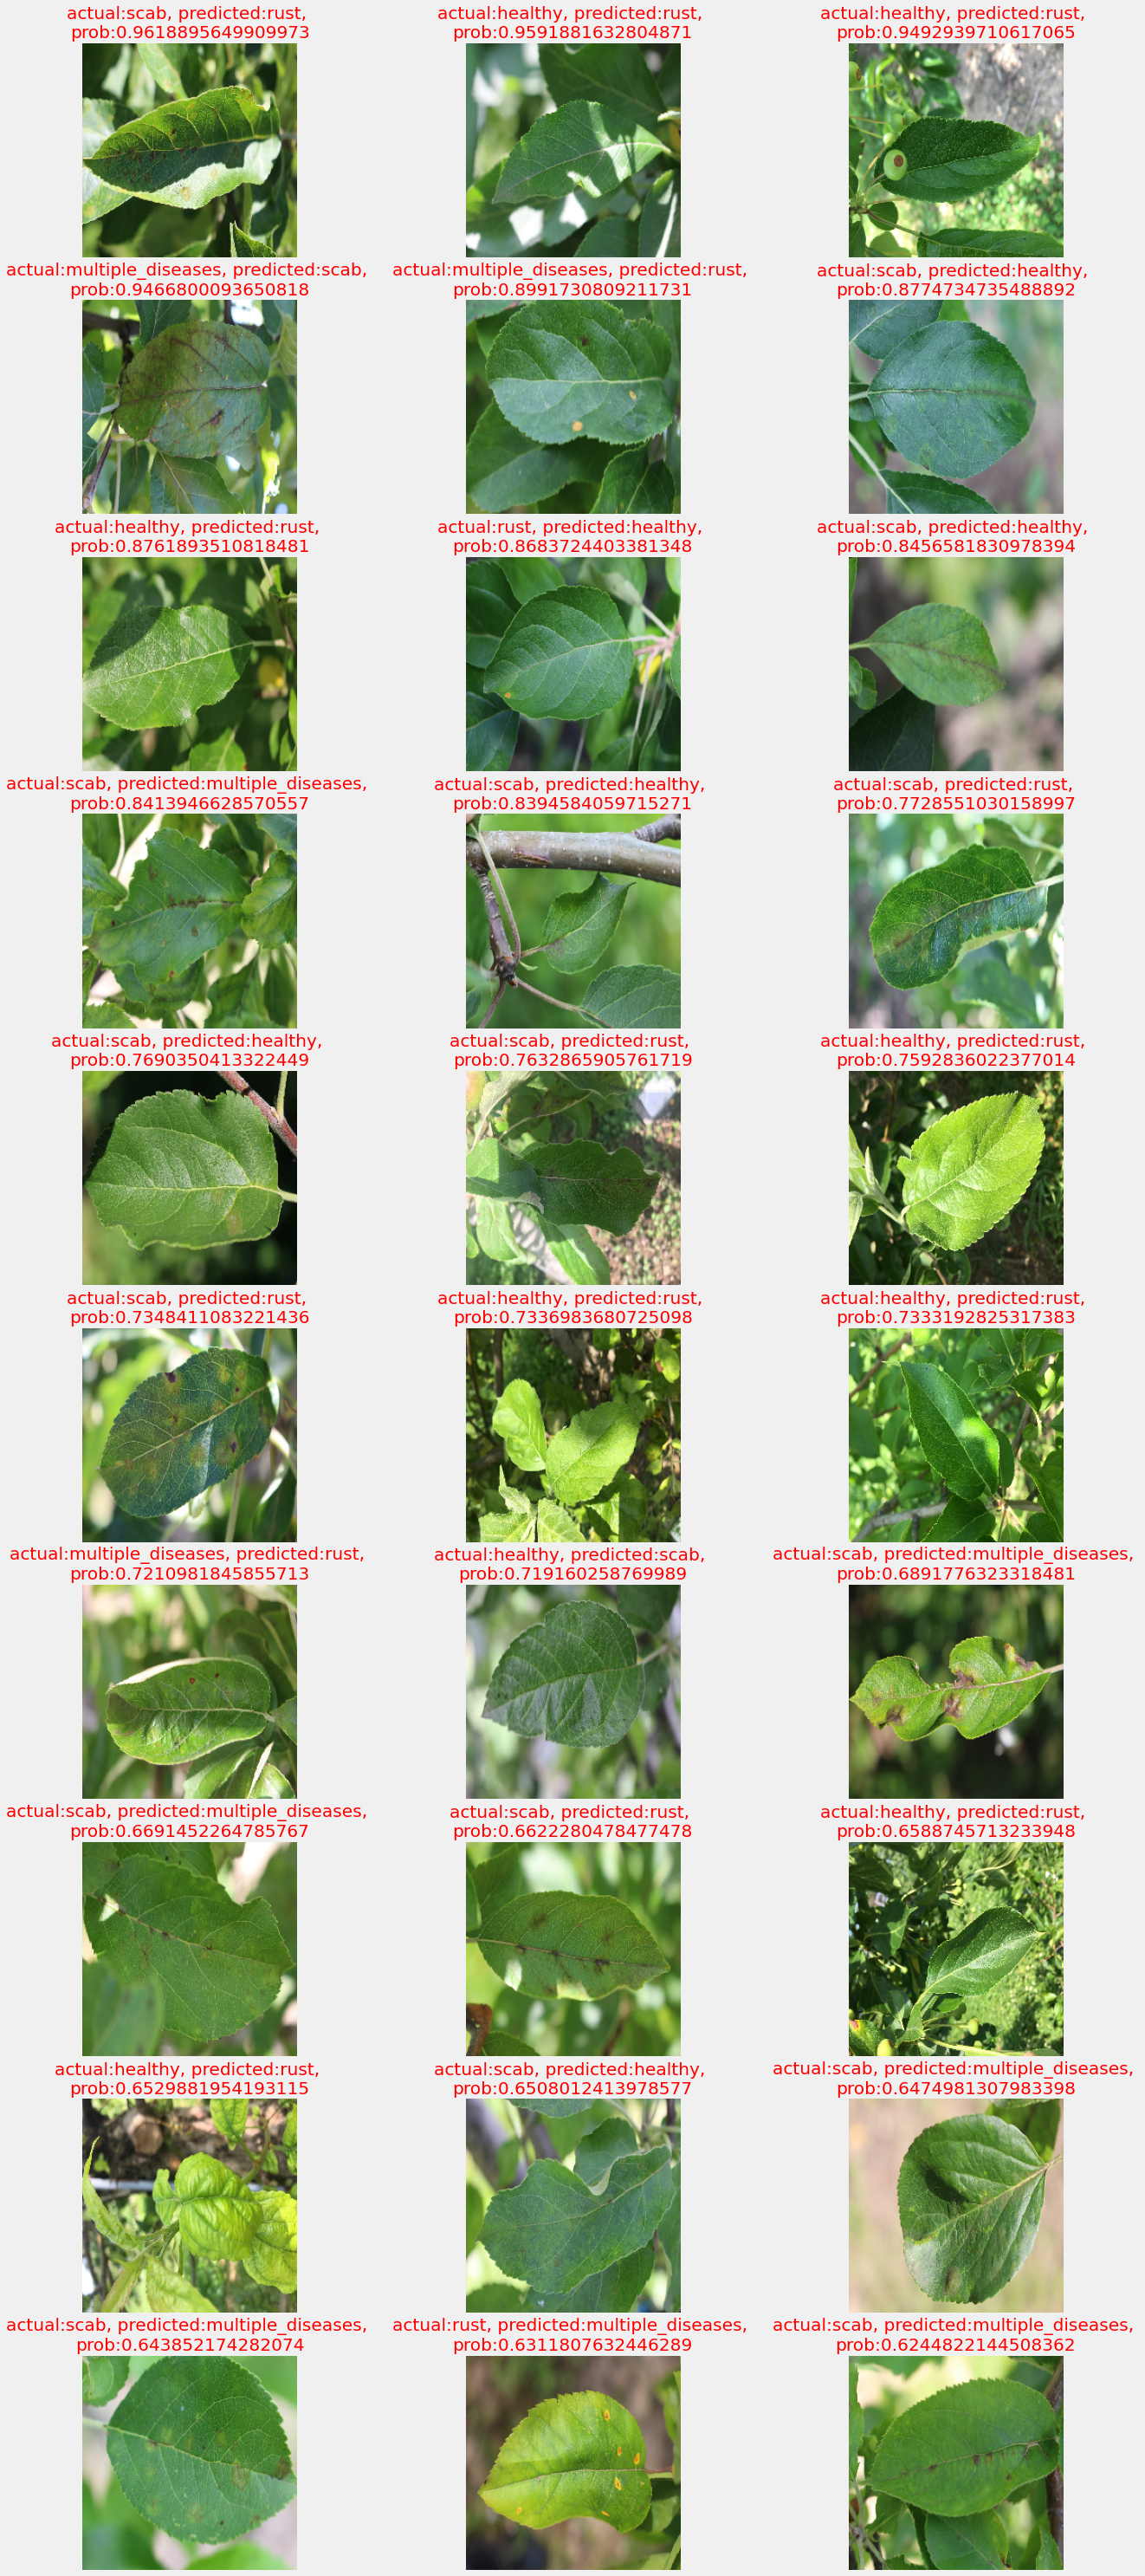

In [ ]:
# 5.visualize the test data samples which have the wrong prediction

max_number = 30
start_number = 0
plt.figure(figsize=(20,50))
for row in df1_wrong_preds.iterrows():
  if start_number >= 30:
    break
  #print(row[1])
  else:
    path = row[1][0]
    actual = class_names[row[1][1]]
    predicted = class_names[row[1][2]]
    score = row[1][3]
    img = load_and_prep_image(path)
    #plt.figure(figsize=(17, 7))
    if actual == predicted:
      color = "g"
    else:
      color = "r"
    plt.subplot(10, 3, start_number + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"actual:{actual}, predicted:{predicted}, \nprob:{score}", c=color)
    start_number = start_number + 1

#### Here We can clearly see that the most wrong predictions or due to wrong labelling and model getting confused, so more number of samples are to be added inorder for the model to work well.

In [ ]:
# Now build a model with shuffling the data
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                 batch_size=32,
                                                                image_size=(224, 224),
                                                                 seed=123)

test_data_shuffled = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                         label_mode="categorical",
                                                                         batch_size=32,
                                                                         image_size=(224,224),
                                                                         seed=123,
                                                                         shuffle=True)

Found 1456 files belonging to 4 classes.
Found 365 files belonging to 4 classes.


In [ ]:
# Build a data_augmentation layer
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.3, 0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
])

In [ ]:
# Build an effnet base model
effnet_B0 = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False,
                                                              weights='imagenet')

# Freeze all the layers
effnet_B0.trainable = False

# Create a input layer
input_ = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# Give the input to the data augmentation layer
x = data_augmentation(input_)

# Add input and dataaugmentation to effnetB4
x = effnet_B0(x, training=False)

# Add a Global average pooling layer
x = tf.keras.layers.GlobalAveragePooling2D(name="Average_pooling")(x)

# Add a Output Dense layer
output = tf.keras.layers.Dense(4, activation="softmax", name="output_layer")(x)

# Build the model
model_new = tf.keras.models.Model(input_, output)

model_new.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
Average_pooling (GlobalAvera (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 4)                 5124      
Total params: 4,054,695
Trainable params: 5,124
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# now let's compile the model
model_new.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])

In [ ]:
# create callbacks
checkpoint_path = "effnetb4_callback"
effnetb4_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor="val_accuracy"
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,monitor="val_accuracy")

In [ ]:
# Fit the data to model
history_effnetb0 = model_new.fit(train_data,
                                 epochs=10,
                                 steps_per_epoch=len(train_data),
                                 validation_data=test_data_shuffled,
                                 validation_steps=len(test_data_shuffled),
                                 callbacks=[effnetb4_checkpoint_cb, early_stopping_cb])

Epoch 1/10
46/46 [==============================] - 19s 289ms/step - loss: 1.1439 - accuracy: 0.4924 - val_loss: 0.9804 - val_accuracy: 0.5562
Epoch 2/10
46/46 [==============================] - 12s 234ms/step - loss: 0.9204 - accuracy: 0.6648 - val_loss: 0.8670 - val_accuracy: 0.6329
Epoch 3/10
46/46 [==============================] - 11s 226ms/step - loss: 0.8432 - accuracy: 0.7088 - val_loss: 0.8614 - val_accuracy: 0.6301
Epoch 4/10
46/46 [==============================] - 11s 225ms/step - loss: 0.8004 - accuracy: 0.7253 - val_loss: 0.7860 - val_accuracy: 0.6959
Epoch 5/10
46/46 [==============================] - 11s 220ms/step - loss: 0.7630 - accuracy: 0.7157 - val_loss: 0.7469 - val_accuracy: 0.7288
Epoch 6/10
46/46 [==============================] - 11s 225ms/step - loss: 0.7262 - accuracy: 0.7459 - val_loss: 0.7075 - val_accuracy: 0.7425
Epoch 7/10
46/46 [==============================] - 11s 221ms/step - loss: 0.7163 - accuracy: 0.7589 - val_loss: 0.6934 - val_accuracy: 0.7562

In [ ]:
# evaluate the model with test
effnet_b0_results = model_new.evaluate(test_data_shuffled)
print(effnet_b0_results)

12/12 [==============================] - 2s 70ms/step - loss: 0.6548 - accuracy: 0.7616
[0.6547780632972717, 0.7616438269615173]


In [ ]:
model_new.save("/content/drive/MyDrive/Plant_pathology/effnetb0_1.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
def plot_loss_curves(history):
  # get the loss values
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # get the accuracy values
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  # no of epochs
  epochs = range(len(loss))

  # plot the loss curves
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Epochs vs loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()

  # plot the accuracy curves
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Epochs vs Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()


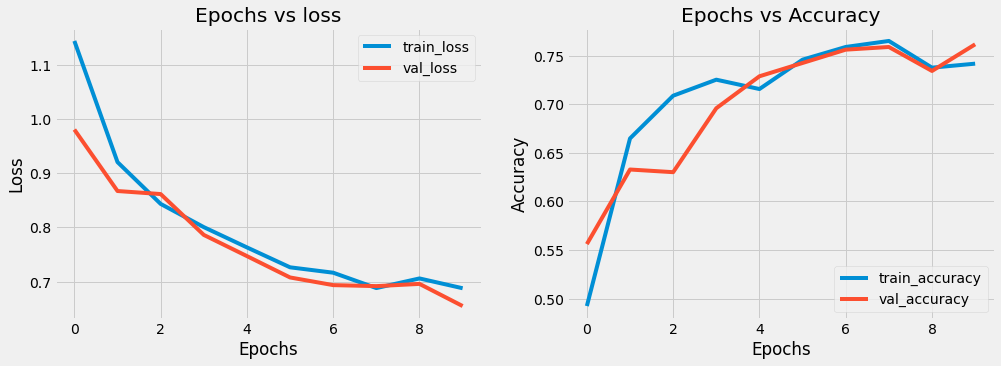

In [ ]:
# plot loss curves
plt.figure(figsize=(15, 5))
plt.style.use('fivethirtyeight')
plot_loss_curves(history_effnetb0)

In [ ]:
# now let's fine the model by unfreezing the last 3 layers
effnet_B0.trainable = True

# freeze all layers except top 3
for layers in effnet_B0.layers[:-3]:
  layers.trainable = False


# Recompile the model
model_new.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=["accuracy"])

# Re-fit the model
fine_tune_epochs = 30
history_fine_tune = model_new.fit(
    train_data,
    epochs=fine_tune_epochs,
    steps_per_epoch=len(train_data),
    validation_data=test_data_shuffled,
    validation_steps=len(test_data_shuffled),
    initial_epoch=history_effnetb0.epoch[-1],
    callbacks=[early_stopping_cb, effnetb4_checkpoint_cb]
)

Epoch 10/30
46/46 [==============================] - 17s 239ms/step - loss: 0.6520 - accuracy: 0.7534 - val_loss: 0.6672 - val_accuracy: 0.7315
Epoch 11/30
46/46 [==============================] - 11s 214ms/step - loss: 0.6248 - accuracy: 0.7685 - val_loss: 0.6186 - val_accuracy: 0.7671
Epoch 12/30
46/46 [==============================] - 10s 204ms/step - loss: 0.6137 - accuracy: 0.7809 - val_loss: 0.5817 - val_accuracy: 0.7918
Epoch 13/30
46/46 [==============================] - 11s 212ms/step - loss: 0.5829 - accuracy: 0.7809 - val_loss: 0.5625 - val_accuracy: 0.8000
Epoch 14/30
46/46 [==============================] - 11s 209ms/step - loss: 0.5758 - accuracy: 0.7871 - val_loss: 0.5816 - val_accuracy: 0.7836
Epoch 15/30
46/46 [==============================] - 11s 209ms/step - loss: 0.5577 - accuracy: 0.7988 - val_loss: 0.5783 - val_accuracy: 0.7808
Epoch 16/30
46/46 [==============================] - 10s 205ms/step - loss: 0.5561 - accuracy: 0.7891 - val_loss: 0.5695 - val_accuracy:

##### Hurrah! This the best model we have built so far
* We may still train for more epochs to increase accuracy but it's not the most effective case
* The most effective will be recorrect the manula labelling mistakes and adding more examples to the data
* Let's save our best model and test it with the testing images and submit our predictions in the kaggle

In [ ]:
test_df = pd.read_csv('test.csv')
test_df.head() 

image_id
0   Test_0
1   Test_1
2   Test_2
3   Test_3
4   Test_4

In [ ]:
def create_test_img_dataset(DIR, custom_path):
  for img in os.listdir(DIR):
      #print(img)
      if img.split(".")[0] in test_df["image_id"].values:
        path = DIR + "/" + img
        #print(path)
        destination = custom_path
        shutil.copy(path, destination)

# Create the directories
os.makedirs('/content/custom-images')

# call the function
custom_path = '/content/custom_images'
create_test_img_dataset(DIR, custom_path)

In [ ]:
print(f"There are {len(os.listdir('/content/custom_images'))} custom_images")

There are 1821 custom_images


In [ ]:
def prep_and_predict_custom_img(path, predictions):
  for image in tqdm(os.listdir(path)):
    image_path = path + "/" + image
    img = load_and_prep_image(image_path)
    #print(img.shape)
    img = tf.expand_dims(img, axis=0)
    prediction_array = model_new.predict(img)
    predictions.append(prediction_array)
  return predictions


In [ ]:
path = "/content/custom_images"
predictions = []
predictions = prep_and_predict_custom_img(path, predictions)

100%|██████████| 1821/1821 [01:45<00:00, 17.34it/s]


In [ ]:
predictions

[array([[0.2106685 , 0.21097746, 0.20902348, 0.36933056]], dtype=float32),
 array([[0.21033178, 0.21023129, 0.20847279, 0.37096417]], dtype=float32),
 array([[0.2104455 , 0.21057016, 0.2087611 , 0.37022325]], dtype=float32),
 array([[0.21023537, 0.21019094, 0.20853147, 0.3710422 ]], dtype=float32),
 array([[0.21044347, 0.21113569, 0.2093265 , 0.36909434]], dtype=float32),
 array([[0.21052782, 0.21084595, 0.20885983, 0.3697664 ]], dtype=float32),
 array([[0.21035661, 0.21048783, 0.20875426, 0.37040126]], dtype=float32),
 array([[0.21028315, 0.21052915, 0.20877677, 0.37041095]], dtype=float32),
 array([[0.21036595, 0.21096362, 0.20916459, 0.36950588]], dtype=float32),
 array([[0.20971072, 0.20949368, 0.20839034, 0.37240526]], dtype=float32),
 array([[0.21025479, 0.21071021, 0.20900933, 0.3700256 ]], dtype=float32),
 array([[0.21056338, 0.21064796, 0.20886339, 0.36992526]], dtype=float32),
 array([[0.21050493, 0.21047024, 0.2087558 , 0.37026903]], dtype=float32),
 array([[0.21076886, 0.21

In [ ]:
healthy = []
multiple_diseases = []
rust = []
scab = []
for array in predictions:
  #print(array[0])
  healthy.append(array[0][0])
  multiple_diseases.append(array[0][1])
  rust.append(array[0][2])
  scab.append(array[0][3])


In [ ]:
submision_df = pd.DataFrame({
    'image_id': test_df["image_id"].values,
    'healthy': healthy,
    'multiple_diseases': multiple_diseases,
    'rust': rust,
    'scab': scab
})

In [ ]:
submision_df.head()

image_id   healthy  multiple_diseases      rust      scab
0   Test_0  0.210669           0.210977  0.209023  0.369331
1   Test_1  0.210332           0.210231  0.208473  0.370964
2   Test_2  0.210445           0.210570  0.208761  0.370223
3   Test_3  0.210235           0.210191  0.208531  0.371042
4   Test_4  0.210443           0.211136  0.209327  0.369094

In [ ]:
submision_df.to_csv('submision.csv', index=False)